In [3]:
import FTIR_functions as FTIR
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c as C

plt.rcParams.update({"image.cmap": 'Greys_r', 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True,})

In [4]:
############# STEP 0 : OPEN IMAGE FILE ##################

source = "ir" # Source nickname as it appears in the file name. "blue" "green" "red" "FBH800" "ir" "FBH1600" "big"
run = 6
file_type = ".tif"
ref = 0 # Referance image. This image will be processed into the spectrum

fringes, beamA, beamB, background = FTIR.import_standard_photo(source, run, file_type)

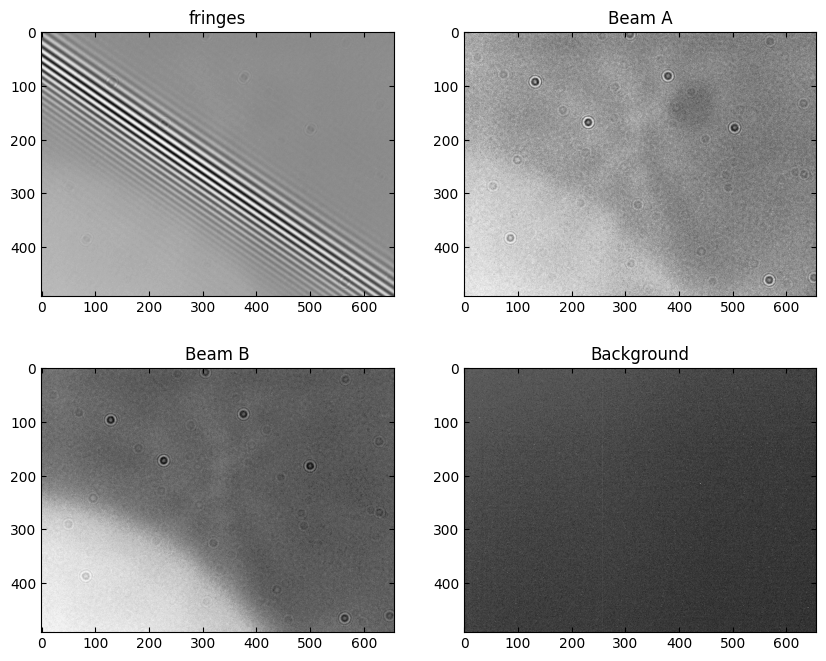

In [5]:
fig, axs = plt.subplots(2, 2, figsize= (10,8))
axs = axs.flatten()

im = axs[0].imshow(fringes[:,:,ref])
axs[0].set(title= "fringes")

axs[1].imshow(beamA)
axs[1].set(title= "Beam A")

axs[2].imshow(beamB)
axs[2].set(title= "Beam B")

axs[3].imshow(background)
axs[3].set(title= "Background")

plt.show()

In [6]:
fringes_subtracted, no_fringes = FTIR.bg_subtract(fringes, beamA, beamB, background, dead_pixels= 0)

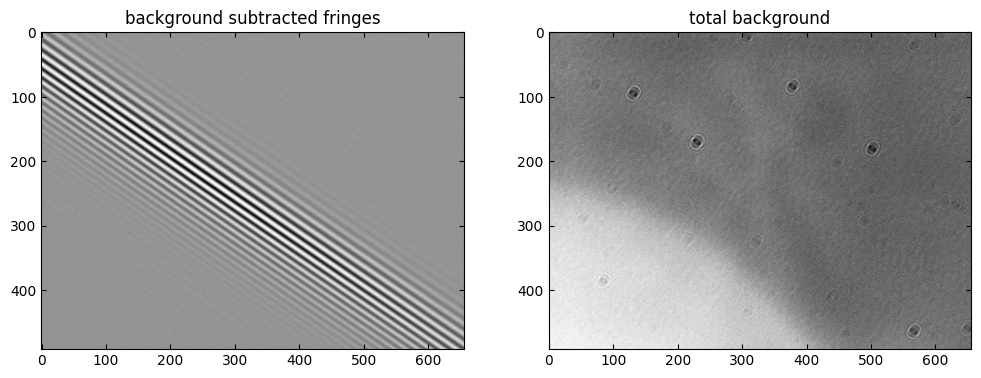

In [7]:
fig, axs = plt.subplots(1, 2, figsize= (12,6))

im = axs[0].imshow(fringes_subtracted[:,:,ref])
axs[0].set(title= "background subtracted fringes")

im = axs[1].imshow(no_fringes[:,:,ref])
axs[1].set(title= "total background")

plt.show()

In [63]:
theta = 5 #arcminutes
camera = "xeva" # camera nickname. "manta" "xeva" "purple" "pyro"

if camera == "manta":
    pixel_pitch = 9.9 #um
elif camera == "xeva":
    pixel_pitch = 20 #um
elif camera == "purple":
    pixel_pitch = 48.5 #um
elif camera == "pyro":
    pixel_pitch = 80 #um
else:
    raise ValueError(camera + " is not a valid camera.")

def sinminutes(arcminutes):
    return np.sin(np.deg2rad(arcminutes/60))

def bounding_box(x_bounds, y_bounds, line_points, line_gradient): # returns the intersection points
    x_bounds = np.sort(x_bounds)
    y_bounds = np.sort(y_bounds)
    line_points = np.array(line_points) #should be (x, y)

    if line_gradient == 0:
        return x_bounds, np.repeat(line_points[1], 2)
    #else:

    x_intercepts = 1/line_gradient *(y_bounds -line_points[1]) +line_points[0]
    is_x_intercept_within_bounds = np.logical_and(x_bounds[0] <= x_intercepts, x_intercepts <= x_bounds[1])
    y_intercepts = line_gradient *(x_bounds -line_points[0]) +line_points[1]
    is_y_intercept_within_bounds = np.logical_and(y_bounds[0] <= y_intercepts, y_intercepts <= y_bounds[1]) #for a rectangle, should equal `np.logical_not(is_x_intercept_within_bounds)`.

    x_intercepts = np.concatenate((x_intercepts[is_x_intercept_within_bounds], x_bounds[is_y_intercept_within_bounds])) #Somehow this works.
    y_intercepts = np.concatenate((y_intercepts[is_y_intercept_within_bounds], y_bounds[is_x_intercept_within_bounds]))   

    return x_intercepts, y_intercepts # This format is compatable with plt.plot(*bounding_box())

rows, columns = fringes_subtracted[:,:,ref].shape

cam_length = columns*pixel_pitch*1e-3 # in mm
cam_height = rows*pixel_pitch*1e-3 # in mm
x = np.linspace(0, cam_length, columns, endpoint= False)
y = np.linspace(0, cam_height, rows, endpoint= False)

FT2d = np.fft.fftshift(np.fft.fft2(fringes_subtracted[:,:,ref], norm= "forward"))

k_x = np.fft.fftshift(np.fft.fftfreq(columns, pixel_pitch*1e-3)) #in mm^-1
k_y = np.fft.fftshift(np.fft.fftfreq(rows, pixel_pitch*1e-3))
dk_x = 1 /(rows*pixel_pitch*1e-3)
dk_y = 1 /(columns*pixel_pitch*1e-3)

freq_x = C*k_x /(2*sinminutes(theta)) *1e3 #convert wavenumber in mm^-1 (as it appears on the camera) to frequency in Hz (of source)
freq_y = C*k_y /(2*sinminutes(theta)) *1e3
dfreq_x = C*dk_x /(2*sinminutes(theta)) *1e3
dfreq_y = C*dk_y /(2*sinminutes(theta)) *1e3


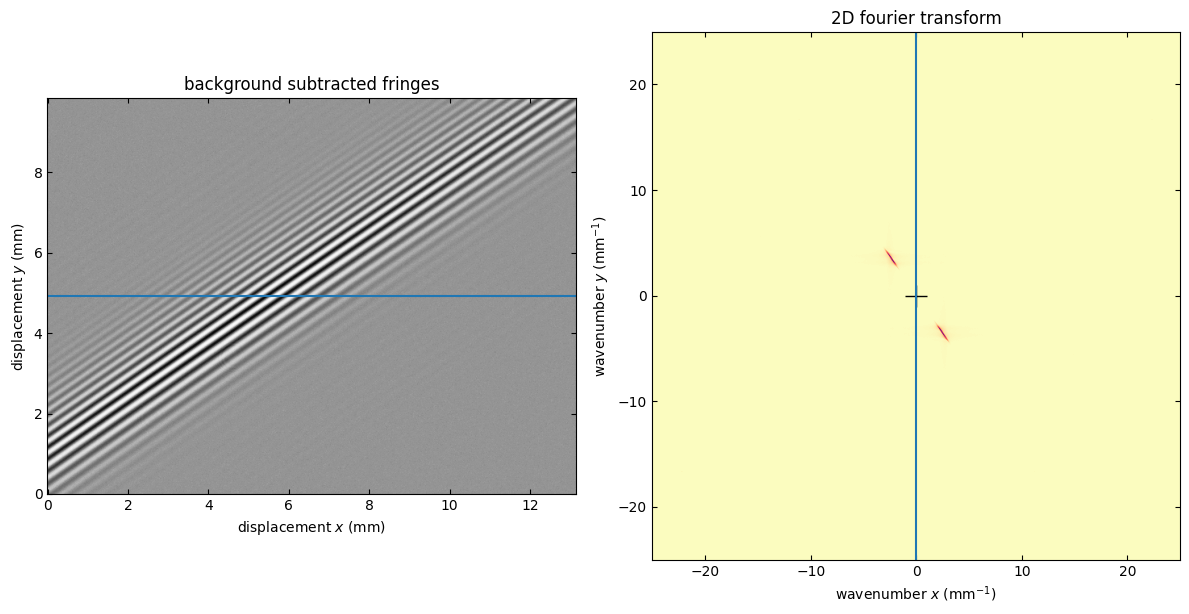

In [77]:
cam_extent=  (-pixel_pitch*1e-3/2, cam_length +pixel_pitch*1e-3/2,
              -pixel_pitch*1e-3/2, cam_height +pixel_pitch*1e-3/2)

k_extent= (k_x[0] -dk_x/2, k_x[-1] +dk_x/2,
           k_y[0] -dk_y/2, k_y[-1] +dk_y/2)

alpha = np.pi/2

fig, axs = plt.subplots(1, 2, figsize= (12,6))

axs[0].imshow(fringes_subtracted[:,:,ref], origin= "lower", extent= cam_extent)
axs[0].plot(*bounding_box((0, cam_length), (0, cam_height), (cam_length/2, cam_height/2), np.tan(alpha +np.pi/2)))
axs[0].set(title= "background subtracted fringes", xlabel= "displacement $x$ (mm)", ylabel= "displacement $y$ (mm)")

axs[1].imshow(np.abs(FT2d), origin= "lower", extent= k_extent, cmap= "magma_r")
axs[1].plot(0, 0, color= "k", marker= "+", markersize= 16) #crosshair
axs[1].plot(*bounding_box((k_x[0], k_x[-1]), (k_y[0], k_y[-1]), (0, 0), np.tan(alpha)))
axs[1].set(title= "2D fourier transform", xlabel= "wavenumber $x$ (mm$^{-1}$)", ylabel= "wavenumber $y$ (mm$^{-1}$)")

plt.tight_layout()
plt.show()

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

# Define the function to plot
def plot_function(alpha):
    fig, axs = plt.subplots(1, 2, figsize= (12,6))

    axs[0].imshow(fringes_subtracted[:,:,ref], origin= "lower", extent= cam_extent)
    axs[0].plot(*bounding_box((0, cam_length), (0, cam_height), (cam_length/2, cam_height/2), np.tan(alpha +np.pi/2)))
    axs[0].set(title= "background subtracted fringes", xlabel= "displacement $x$ (mm)", ylabel= "displacement $y$ (mm)")

    axs[1].imshow(np.abs(FT2d), origin= "lower", extent= k_extent, cmap= "magma_r")
    axs[1].plot(0, 0, color= "k", marker= "+", markersize= 16) #crosshair
    axs[1].plot(*bounding_box((k_x[0], k_x[-1]), (k_y[0], k_y[-1]), (0, 0), np.tan(alpha)))
    axs[1].set(title= "2D fourier transform", xlabel= "wavenumber $x$ (mm$^{-1}$)", ylabel= "wavenumber $y$ (mm$^{-1}$)")

    plt.show()

# Create interactive variable
decimal_places = 1
alpha_slider = widgets.BoundedFloatText(value=0.0, min=np.round(-np.pi/2, decimal_places), max=np.round(np.pi/2, decimal_places), step= 10**-decimal_places, description='alpha (rad):', disabled= False)

# Connect the slider to the plot function
interactive_plot = interactive(plot_function, {"manual": True}, alpha=alpha_slider)

display(interactive_plot)

interactive(children=(BoundedFloatText(value=0.0, description='alpha (rad):', max=1.6, min=-1.6, step=0.1), Bu…